# Kinetic Modeling with PYthon (kmpy)

In [1]:
import os, sys
import numpy as np
from constants import GAS_CONST, PR_ATM
from constants import KCAL_JL, HT_JL
import pandas as pd
import math
import re
from assimulo.solvers import CVode
from assimulo.problem import Explicit_Problem
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors
from rdkit import Chem
import rdkit.Chem.Draw as Draw
import rdkit.Chem.rdChemReactions as ChemReac
from PIL import Image, ImageOps
from collections import defaultdict
from SALib.sample import saltelli
from SALib.analyze import sobol


Could not find GLIMDA.


In [2]:
cwd = os.getcwd()

setting up the paths for the input files

In [3]:
def set_paths(myPath):
    """
    Set the absolute path to required files on the current machine.

    Returns
    -------
    reactionlist_path     : str
                            path to the file `complete_reactionlist.dat`
    rateconstantlist_path : str
                            path to the file `complete_rateconstantlist.dat`
    free_enenry_path      : str
                            path to the file `compositionlist.dat`
    """
    #myPath = os.path.dirname(os.path.abspath(__file__))
#     reactionlist_path = myPath + '/data/complete_reaction_list.dat'
#     rateconstantlist_path = myPath + '/data/complete_rateconstant_list.dat'
#     free_energy_path = myPath + '/data/free_energy_library.dat'
    reactionlist_path = myPath + '/../kmpy/data/complete_reaction_list.dat'
    rateconstantlist_path = myPath + '/../kmpy/data/complete_rateconstant_list.dat'
    free_energy_path = myPath + '/../kmpy/data/free_energy_library.dat'
    return reactionlist_path, rateconstantlist_path, free_energy_path


In [4]:
file_reactionlist, file_rateconstantlist, file_free_energy = set_paths(cwd)

In [5]:
df_rate = pd.read_csv(file_rateconstantlist, header = None, sep = ' ')
df_rate.head()

,0,1,2
0,5.000000e+15,0,57.0
1,5.000000e+15,0,57.0
2,6.000000e+15,0,59.0
3,3.000000e+13,0,47.0
4,9.000000e+12,0,46.1


In [6]:
df_free_energy = pd.read_csv(file_free_energy, sep = '\t')
df_free_energy.head()

,Structure ID,smiles,electronic_energy,300K,400K,500K,600K,700K,800K
0,1,O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O,-572.654636,0.130831,0.114449,0.096034,0.075704,0.053580,0.029778
1,2,O,-76.422977,0.003836,-0.003547,-0.011258,-0.019238,-0.027448,-0.035861
2,3,OC1=COC[C@@H](O)[C@@H]1O,-496.193201,0.103466,0.088156,0.071087,0.052368,0.032109,0.010414
3,4,OC1=C[C@@H](O)[C@H](O)OC1,-496.205201,0.104026,0.088926,0.072080,0.053591,0.033566,0.012107
4,5,O[C@H]1C=CO[C@@H](O)[C@@H]1O,-496.204142,0.104043,0.088886,0.071984,0.053439,0.033355,0.011835


In [7]:
class Reaction(object):
    
    
    def __init__(self):
        self.reactants_names = []
        self.products_names = []
        self.uniqueSpeciesList = []
        #species_names = []
        
   
    def getReactantsName(self, line):
        
        for spec in line.split(','):
            if float(spec.split('_')[0].split()[0]) < 0:
                self.reactants_names.append((spec.split('_')[0].split()[0],
                                          spec.split('_')[1].split()[0]))
            #print(self.species_names)
        return self.reactants_names
    
    def getProductsName(self, line):
        
        for spec in line.split(','):
            if float(spec.split('_')[0].split()[0]) > 0:
                self.products_names.append((spec.split('_')[0].split()[0],
                                          spec.split('_')[1].split()[0]))
            #print(self.species_names)
        return self.products_names
    
    def uniqueSpeciesName(self, line, species_list):
        #self.uniqueSpeciesList = species_list
        for spec in line.split(','):
            #self.uniqueSpeciesList = species_list
            # If the species has already been added to the list then move on.
            if spec.split('_')[1].split()[0] in species_list:
                self.uniqueSpeciesList = species_list
                continue
            else:
                #print(self.uniqueSpeciesList)
                self.uniqueSpeciesList = species_list
                self.uniqueSpeciesList.append(spec.split('_')[1].split()[0])
            #print(spec.split('_')[1].split()[0])
        return self.uniqueSpeciesList
    

In [8]:
def build_species_list(reaction_file):
    """
    Build reactnat and product list for each reaction. Also builds a list
    of unique species in the mechanism
    Parameters
    ----------
    reaction_file       : str
                           path to the file `complete_reaction_list.dat`
    Returns
    ----------
    reactant_list       : list
                         a list of the reactants and their stoichiometric
                         coeffs for each reaction
    product_list        : list
                         a list of the products and their stoichiometric
                         coeffs for each reaction
    species_list        : list
                        a list of unique species in the mechanism
    """

    #initializing reactant, product and unique species list
    reactant_list = []
    product_list = []
    species_name = []

    for line in open(reaction_file, 'r').readlines():
        reac = Reaction()
        reactant_list.append(reac.getReactantsName(line))
        product_list.append(reac.getProductsName(line))
        current_species = species_name
        #print(current_species)
        species_list = reac.uniqueSpeciesName(line, current_species)
        #print(species_name)
    species_list.sort()

    return reactant_list, product_list, species_list

reactants_list, products_list, unique_species = build_species_list(file_reactionlist)
    

In [9]:
print(unique_species)
print(len(unique_species))

['C(=O)=O', 'C=C(O)C=O', 'C=C(O)[C@@H](O)[C@H](O)C=O', 'C=O', 'CC(=O)/C=C(/O)C=O', 'CC(=O)C=O', 'CC(=O)CC(=O)C=O', 'CC(=O)CO', 'CC(=O)[C@@H](O)[C@H](O)C=O', 'CC=O', 'O', 'O/C=C/O', 'O=C/C=C(\\O)[C@@H](O)CO', 'O=C/C=C/C(=O)CO', 'O=C/C=C\\[C@@H](O)C=O', 'O=C1COC=C[C@@H]1O', 'O=C1COCC(=O)C1', 'O=C1COC[C@@H](O)[C@@H]1O', 'O=CC(O)C=O', 'O=CC1=C[C@@H](O)CO1', 'O=CC=O', 'O=CCC(=O)[C@@H](O)CO', 'O=CCC=O', 'O=CCO', 'O=CC[C@H](O)[C@@H](O)C=O', 'O=CC[C@H](O)[C@H](O)C=O', 'O=C[C@@H](O)/C=C(\\O)CO', 'O=C[C@@H](O)CC(=O)CO', 'O=C[C@@H](O)[C@@H](O)/C=C\\O', 'O=C[C@@H](O)[C@@H](O)CO', 'O=C[C@@H](O)[C@H](O)[C@@H](O)CO', 'O=C[C@H](O)/C=C(/O)CO', 'O=C[C@H](O)CC(=O)CO', 'O=C[C@H](O)CO', 'O=C[C@H](O)[C@@H](O)/C=C\\O', 'O=C[C@H]1OC[C@H](O)[C@H]1O', 'O=Cc1ccco1', 'OC1=COC=C[C@@H]1O', 'OC1=COCC(O)=C1', 'OC1=COC[C@@H](O)[C@@H]1O', 'OC1=C[C@@H](O)[C@H](O)OC1', 'O[C@H]1C=CO[C@@H](O)[C@@H]1O', 'O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O', '[C]', '[C]=O', '[HH]']
46


In [10]:
#print(len(products_list))
print(products_list)

[[('1.0', 'O'), ('1.0', 'OC1=COC[C@@H](O)[C@@H]1O')], [('1.0', 'O'), ('1.0', 'OC1=C[C@@H](O)[C@H](O)OC1')], [('1.0', 'O'), ('1.0', 'O[C@H]1C=CO[C@@H](O)[C@@H]1O')], [('1.0', 'O=C[C@@H](O)[C@H](O)[C@@H](O)CO')], [('1.0', 'O=C[C@H](O)[C@@H](O)/C=C\\O')], [('1.0', 'O=CC[C@H](O)[C@@H](O)C=O')], [('1.0', 'O=CCO'), ('1.0', 'O=CCC=O')], [('1.0', 'O'), ('1.0', 'O=C/C=C\\[C@@H](O)C=O')], [('1.0', 'O'), ('1.0', 'OC1=COC=C[C@@H]1O')], [('1.0', 'O=C[C@H](O)/C=C(/O)CO')], [('1.0', 'O=C[C@H](O)CC(=O)CO')], [('1.0', 'O'), ('1.0', 'O=C/C=C/C(=O)CO')], [('1.0', 'CC(=O)CO'), ('1.0', 'O=CC=O')], [('1.0', 'O'), ('1.0', 'OC1=COCC(O)=C1')], [('1.0', 'O=C1COCC(=O)C1')], [('1.0', 'O'), ('1.0', 'OC1=COCC(O)=C1')], [('1.0', 'O=C1COC[C@@H](O)[C@@H]1O')], [('1.0', 'C=C(O)[C@@H](O)[C@H](O)C=O')], [('1.0', 'CC(=O)[C@@H](O)[C@H](O)C=O')], [('1.0', 'CC(=O)C=O'), ('1.0', 'O=CCO')], [('1.0', 'O'), ('1.0', 'CC(=O)/C=C(/O)C=O')], [('1.0', 'CC(=O)CC(=O)C=O')], [('1.0', 'O'), ('1.0', 'OC1=COC=C[C@@H]1O')], [('1.0', 'O=C1CO

In [11]:
reac_prod_list = [react + prod for react, prod in zip(reactants_list, products_list)]
# for react, prod in zip(reactants, products):
#     total.append(react + prod)
#print(total)

In [12]:
print(reac_prod_list)

[[('-1.0', 'O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O'), ('1.0', 'O'), ('1.0', 'OC1=COC[C@@H](O)[C@@H]1O')], [('-1.0', 'O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O'), ('1.0', 'O'), ('1.0', 'OC1=C[C@@H](O)[C@H](O)OC1')], [('-1.0', 'O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O'), ('1.0', 'O'), ('1.0', 'O[C@H]1C=CO[C@@H](O)[C@@H]1O')], [('-1.0', 'O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O'), ('1.0', 'O=C[C@@H](O)[C@H](O)[C@@H](O)CO')], [('-1.0', 'O[C@H]1C=CO[C@@H](O)[C@@H]1O'), ('1.0', 'O=C[C@H](O)[C@@H](O)/C=C\\O')], [('-1.0', 'O=C[C@H](O)[C@@H](O)/C=C\\O'), ('1.0', 'O=CC[C@H](O)[C@@H](O)C=O')], [('-1.0', 'O=CC[C@H](O)[C@@H](O)C=O'), ('1.0', 'O=CCO'), ('1.0', 'O=CCC=O')], [('-1.0', 'O=CC[C@H](O)[C@@H](O)C=O'), ('1.0', 'O'), ('1.0', 'O=C/C=C\\[C@@H](O)C=O')], [('-1.0', 'O[C@H]1C=CO[C@@H](O)[C@@H]1O'), ('1.0', 'O'), ('1.0', 'OC1=COC=C[C@@H]1O')], [('-1.0', 'OC1=C[C@@H](O)[C@H](O)OC1'), ('1.0', 'O=C[C@H](O)/C=C(/O)CO')], [('-1.0', 'O=C[C@H](O)/C=C(/O)CO'), ('1.0', 'O=C[C@H](O)CC(=O)CO')], [('-1.0', 'O=C[C@H](O)CC(=O)CO'), (

In [13]:
#generating a dictionary of unique species from the species_list
speciesindices = {unique_species[i]: i for i in range(0, len(unique_species))}

indices_to_species = dict(zip(speciesindices.values(), speciesindices.keys()))

In [14]:
speciesindices
#indices_to_species

{'C(=O)=O': 0,
 'C=C(O)C=O': 1,
 'C=C(O)[C@@H](O)[C@H](O)C=O': 2,
 'C=O': 3,
 'CC(=O)/C=C(/O)C=O': 4,
 'CC(=O)C=O': 5,
 'CC(=O)CC(=O)C=O': 6,
 'CC(=O)CO': 7,
 'CC(=O)[C@@H](O)[C@H](O)C=O': 8,
 'CC=O': 9,
 'O': 10,
 'O/C=C/O': 11,
 'O=C/C=C(\\O)[C@@H](O)CO': 12,
 'O=C/C=C/C(=O)CO': 13,
 'O=C/C=C\\[C@@H](O)C=O': 14,
 'O=C1COC=C[C@@H]1O': 15,
 'O=C1COCC(=O)C1': 16,
 'O=C1COC[C@@H](O)[C@@H]1O': 17,
 'O=CC(O)C=O': 18,
 'O=CC1=C[C@@H](O)CO1': 19,
 'O=CC=O': 20,
 'O=CCC(=O)[C@@H](O)CO': 21,
 'O=CCC=O': 22,
 'O=CCO': 23,
 'O=CC[C@H](O)[C@@H](O)C=O': 24,
 'O=CC[C@H](O)[C@H](O)C=O': 25,
 'O=C[C@@H](O)/C=C(\\O)CO': 26,
 'O=C[C@@H](O)CC(=O)CO': 27,
 'O=C[C@@H](O)[C@@H](O)/C=C\\O': 28,
 'O=C[C@@H](O)[C@@H](O)CO': 29,
 'O=C[C@@H](O)[C@H](O)[C@@H](O)CO': 30,
 'O=C[C@H](O)/C=C(/O)CO': 31,
 'O=C[C@H](O)CC(=O)CO': 32,
 'O=C[C@H](O)CO': 33,
 'O=C[C@H](O)[C@@H](O)/C=C\\O': 34,
 'O=C[C@H]1OC[C@H](O)[C@H]1O': 35,
 'O=Cc1ccco1': 36,
 'OC1=COC=C[C@@H]1O': 37,
 'OC1=COCC(O)=C1': 38,
 'OC1=COC[C@@H](O)[C@@H]1O'

In [15]:
# reac_matrix = np.zeros((len(reac_prod_list),len(unique_species)), dtype = float)
# reac_matrix

In [16]:
# for rxnindex, reac_list in enumerate(reac_prod_list):
#     for x in range (len(reac_list)):
#         species = reac_list[x][1]
#         for i in range (len(unique_species)):
#             if i == speciesindices[species]:
#                 reac_matrix[rxnindex][i] = float(reac_list[x][0])

# print(reac_matrix)
                

Next, we need to build the rate constants for all the reactions. The forward rate constants can be calculated using Arrhenius equation

$k_f = A T^n exp (\frac{-E_a}{RT}) $

In [17]:
class Kinetic_params(object):
      
    def __init__(self):
        self.forward_rate_params = []
        self.forward_rates = []
        #self.forward_E = []
        #self.uniqueSpeciesList = []
        #species_names = []
    
    def getForwardRateParameters(self, line):
        
        self.forward_rate_params = [line.split(' ')[0], line.split(' ')[1],
                                    line.split(' ')[2].split()[0]]
      
        return self.forward_rate_params
    
    def getForwardRateConstant(self, parameters, T):
        
        self.forward_rates = (eval(parameters[0]) * T ** eval(parameters[1]) *
                             np.exp(- eval(parameters[2]) * KCAL_JL / (GAS_CONST * T)))
        return self.forward_rates

In [18]:

T = 773


In [19]:
def build_kmatrix_forward(rateconstantlist, temp):
    
    rate_constants = []
    for line in open(rateconstantlist, 'r').readlines():
        f_params = Kinetic_params()
        params = f_params.getForwardRateParameters(line)
        #print(params)
        rate_constants.append(f_params.getForwardRateConstant(params, temp))
    return rate_constants

In [20]:
forward_rate_constants = build_kmatrix_forward(file_rateconstantlist, T)
forward_rate_constants

[0.38266520209580795,
 0.38266520209580795,
 0.12488815036321174,
 1.5429972059873165,
 0.8316717256184595,
 0.5858572157369561,
 4.126500721594635,
 3.160872033570743,
 0.38266520209580795,
 0.8316717256184595,
 0.5858572157369561,
 3.160872033570743,
 4.126500721594635,
 0.38266520209580795,
 0.5858572157369561,
 0.38266520209580795,
 0.5858572157369561,
 0.8316717256184595,
 0.5858572157369561,
 4.767955156601945,
 3.160872033570743,
 0.5858572157369561,
 0.12488815036321174,
 0.5858572157369561,
 3.160872033570743,
 77.75627930448483,
 0.5298936523397635,
 3.160872033570743,
 0.5858572157369561,
 4.126500721594635,
 3.160872033570743,
 0.5858572157369561,
 4.126500721594635,
 0.38266520209580795,
 3.160872033570743,
 0.5858572157369561,
 4.126500721594635,
 4.126500721594635,
 6.317638003793984,
 4.767955156601945,
 4.126500721594635,
 0.38266520209580795,
 0.3186644996634748,
 0.3186644996634748,
 0.3186644996634748,
 0.3186644996634748,
 0.3186644996634748,
 0.3186644996634748,
 

Next, to calculate the reverse rate constants, we need to calculate the thermodynamic equilibrium constants using the folloing equation

$ K_{eq} = exp (-{\Delta G}/ RT)$

since, we have free energy corrections for all the species at a few specific temperature, we need to calculate it for any given temperature using linear interpolation

In [21]:
def build_free_energy_dict(free_energy_path, temp):
    """
    Build a dictionary of free energy at a given temperature for all the species 
    present in the mechanism. It reads the file free_energy_path which is basically
    a library of gibbs free energy correction at different molecules at different temperatures.
    Parameters
    ----------
    completereactionlist : str
                           path to the file `free_energy_library.dat`
    T                    : float
                           temperature to calculate free energy
    Returns
    -------
    free_energy.    : dict
                    a dictionary where keys are unique species and values
                    are free energy of species at a given temperature 
                    build from free_energy_library.dat
    """
    
    df = pd.read_csv(free_energy_path, sep = '\t')

    if "{}K".format(temp) in df.columns:
        df["Free Energy @{}K".format(temp)] = df['electronic_energy'] + df["{}K".format(temp)]
    else:
        temp_low = math.floor(temp / 100.0)* 100
        temp_high = math.ceil(temp / 100.0)* 100
        df["{}K".format(temp)] = (df["{}K".format(temp_high)] - df["{}K".format(temp_low)])*(temp - temp_low)/(temp_high - temp_low) + df["{}K".format(temp_low)]
        df["Free Energy @{}K".format(temp)] = df['electronic_energy'] + df["{}K".format(temp)]
    #print(df.head())
    
    free_energy = dict([(i, a) for i, a  in zip(df.smiles, df["Free Energy @{}K".format(temp)])])
    
    return free_energy

In [22]:
free_energy_dict = build_free_energy_dict(file_free_energy, T)
#print(free_energy_dict)

In [23]:
def build_free_energy_change(complete_list, free_energy):
    """
    Calculate the reverse rate constants of all the reactions. There are two steps 
    doing this
    1. Calculate the change in free energy for each reaction
            delG = G(products) - G(reactanat)
    This is calculated from the complete lists of reactions and free_energy_dict
    2. Use delG to calculate the equlilibrium constant
            Keq = exp (- delG/Gas Const * Temp)
    3. Use the following equation to calculate the reverse rate constant
            Keq = Kf / Kr * (Gas Const * Temp / Pressure)^n
    where n = total number of product molecules - total number of reactant molecules
    ----------
    complete_list        : list
                           A list of all the reactions with reactant and 
                         product species and their stoichimetric coeffs
    free_energy          : dict
                          A dictionary of free energies of all the species
                          at a given temperature, obtained from 
                          build_free_energy_dict function
    forward_rate         : A list of forward rate constants for all the reactions
                         obtained from build_forward_reaction_rates
    T                    : float
                           temperature to calculate free energy
    Returns
    -------
     reverse_rates       : list
                         A list of reverse rate constants
    """
    
    
    mol_change = []
    gibbs_energy_list = []

    for i, item in enumerate (complete_list):
        n_reac = 0
        n_prod = 0
        reac_free_energy = 0
        prod_free_energy = 0
        for entry in item:
        
            if float(entry[0]) < 0:
                n_reac = n_reac + abs(float(entry[0]))
                reac_free_energy = abs(float(entry[0])) * free_energy[entry[1]] + reac_free_energy
            else:
                prod_free_energy = abs(float(entry[0])) * free_energy[entry[1]] + prod_free_energy
                n_prod = n_prod + abs(float(entry[0]))
        #print(n_reac)
        mol_change.append(n_prod - n_reac)
        gibbs_energy_list.append((prod_free_energy - reac_free_energy) * HT_JL)
    
    return gibbs_energy_list, mol_change
    

In [24]:
gibbs_energy, mol = build_free_energy_change(reac_prod_list, free_energy_dict)
gibbs_energy

[-39.55381387475552,
 -66.78240178488232,
 -64.67131599969332,
 6.396059314942818,
 14.802070154989707,
 -39.371341625066975,
 -85.98173810505571,
 -54.131114974784396,
 -56.38279628517063,
 10.054693564958683,
 -43.08403491998516,
 -62.10591369512005,
 -72.6189670499841,
 -50.23631700017077,
 -75.41740873495996,
 -77.46490491029758,
 -37.09747483999047,
 -15.02108936516504,
 -56.460274789846665,
 -62.54597375028354,
 -86.63871697022074,
 -11.611930125008826,
 -81.50029841025767,
 -0.013390050025890332,
 -64.54665725960211,
 -71.50948326037948,
 -143.44883963470647,
 -67.94242644988168,
 -35.61330594499762,
 -80.16134591994893,
 -82.06289054957153,
 -32.0507387400765,
 -53.901199940069375,
 11.962381865126929,
 -94.75909966478588,
 -11.448571514663115,
 -75.41071371032012,
 -73.08236780000806,
 -94.93246142985859,
 -41.889353654804665,
 -44.8966538651039,
 -42.85860948995136,
 2406.702658927644,
 2433.9312468377707,
 2423.876553272812,
 2466.9605881927973,
 2466.9605881927973,
 2425.29

Now, after all these, we can calculate the thermodynamic equilibrium constants using the folloing equation

$ K_{eq} = exp (-\frac{\Delta G}{RT})$

In [25]:
equilibrium_constants = [np.exp(-n * 1000 /(GAS_CONST * T)) for n in gibbs_energy]
equilibrium_constants

[470.87190713949985,
 32577.042148094013,
 23455.90294378285,
 0.36963883325921953,
 0.09993784328947083,
 457.69057585049507,
 646149.3620436967,
 4549.710184173041,
 6458.685845878702,
 0.2091897515832769,
 815.5719303118755,
 15735.900661936048,
 80784.0249429861,
 2481.9181872556887,
 124863.06498057899,
 171710.2935393339,
 321.3011861164004,
 10.353103321034945,
 6537.02093910691,
 16851.139046231096,
 715696.9400922568,
 6.091047338610572,
 321731.4646548906,
 1.0020856680554784,
 23005.31435248106,
 67975.21831016376,
 4940267696.959592,
 39021.31443553529,
 255.04545971942758,
 261223.35323697756,
 351165.19502120547,
 146.51168779329873,
 4389.822011398942,
 0.15546254467416576,
 2532066.2688198057,
 5.938172295507727,
 124733.05686488345,
 86824.12665409726,
 2601298.705899904,
 677.2204413497724,
 1081.3155817827337,
 787.4606120872136,
 2.3109673215668066e-163,
 3.3402958595701075e-165,
 1.5967779655974948e-164,
 1.9578628276072762e-167,
 1.9578628276072762e-167,
 1.279648

Finally, we can calculate the reverse rate constants using the following equaion


$ K_{eq} = \frac{k_f}{k_r} (\frac{1000RT}{P})^{\Delta n}$, ${\Delta n}$ = number of product molecules - number of reactant molecules

multiplied by 1000 to convert it from $ \frac{m^3}{mol*s}$ to $ \frac{L}{mol*s}$

In [26]:
def build_kmatrix_reverse(complete_list, free_energy,
                          forward_rates, temperature):
    
    gibbs_energy, change_mol = build_free_energy_change(complete_list,
                                                        free_energy)

    equilibrium_constants = [np.exp(-n * 1000/(GAS_CONST * temperature))
                             for n in gibbs_energy]

    reverse_rates = [(a / b) * (GAS_CONST * temperature * 1000 / PR_ATM) ** c
                     if c < 3 else 0 for (a, b, c) in
                     zip(forward_rates, equilibrium_constants, change_mol)]

    return reverse_rates

reverse_rate_constants = build_kmatrix_reverse(reac_prod_list, free_energy_dict, forward_rate_constants, T)
reverse_rate_constants

[0.05154530244729928,
 0.0007450410862074591,
 0.0003377084903080553,
 4.174337399515723,
 8.321889869181138,
 0.0012800290122825836,
 0.00040506237725199254,
 0.04406523419391019,
 0.0037579215720686676,
 3.9756810232043183,
 0.0007183391114416159,
 0.012740550991463678,
 0.0032398830936437814,
 0.009779224388648916,
 4.69199771628287e-06,
 0.00014134991191941732,
 0.0018233895206496776,
 0.08033066992857188,
 8.96214378375536e-05,
 0.017946336292793564,
 0.0002801242167587861,
 0.09618332992148373,
 2.4620711500673443e-05,
 0.5846378552382623,
 0.008714683994673676,
 0.0725533987563605,
 6.803167067460189e-09,
 0.005137808597176053,
 0.002297069770939857,
 0.0010019425652646006,
 0.0005709109206221215,
 0.003998706345963974,
 0.059622188774316666,
 2.461462359939088,
 7.917804018354099e-05,
 0.09865951787558633,
 0.002098327446049823,
 0.003014493859431491,
 0.0001540413848406058,
 0.4465550502839816,
 0.24204848340183002,
 0.0004859483715401713,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 

In [27]:
# def build_stoic_matrix(complete_list, species_list, species_indices):

#     matrix = np.zeros((len(complete_list),len(species_list)), dtype = float)
#     rate_final = []
#     for rxnindex, reac_list in enumerate(complete_list):
#         #rate = ''
#         rate_f = 'kf[%s] ' %rxnindex
#         rate_r = '- kr[%s]' %rxnindex
#         concentration_f = ''
#         concentration_r = ''
#         for x in range (len(reac_list)):
#             species = reac_list[x][1]
#             for i in range (len(species_list)):
#                 if i == species_indices[species]:
#                     matrix[rxnindex][i] = float(reac_list[x][0])
#                     if float(reac_list[x][0]) < 0:
#                         if abs(float(reac_list[x][0])) == 1:
#                             concentration_f += '* y[%s] ' % i
#                         else:    
#                             concentration_f += '* y[%s] ** %s ' % (i, abs(float(reac_list[x][0])))
#                     else:
#                         if abs(float(reac_list[x][0])) == 1:
#                             concentration_r += '* y[%s] ' % i
#                         else:    
#                             concentration_r += '* y[%s] ** %s ' % (i, float(reac_list[x][0]))
        
#         rate = rate_f + concentration_f + rate_r + concentration_r  
#         #print(rate)
#         rate_final.append(rate)
#     return matrix, rate_final

It is easier to create the stoichiometric matrix and operate on that to build the ODEs
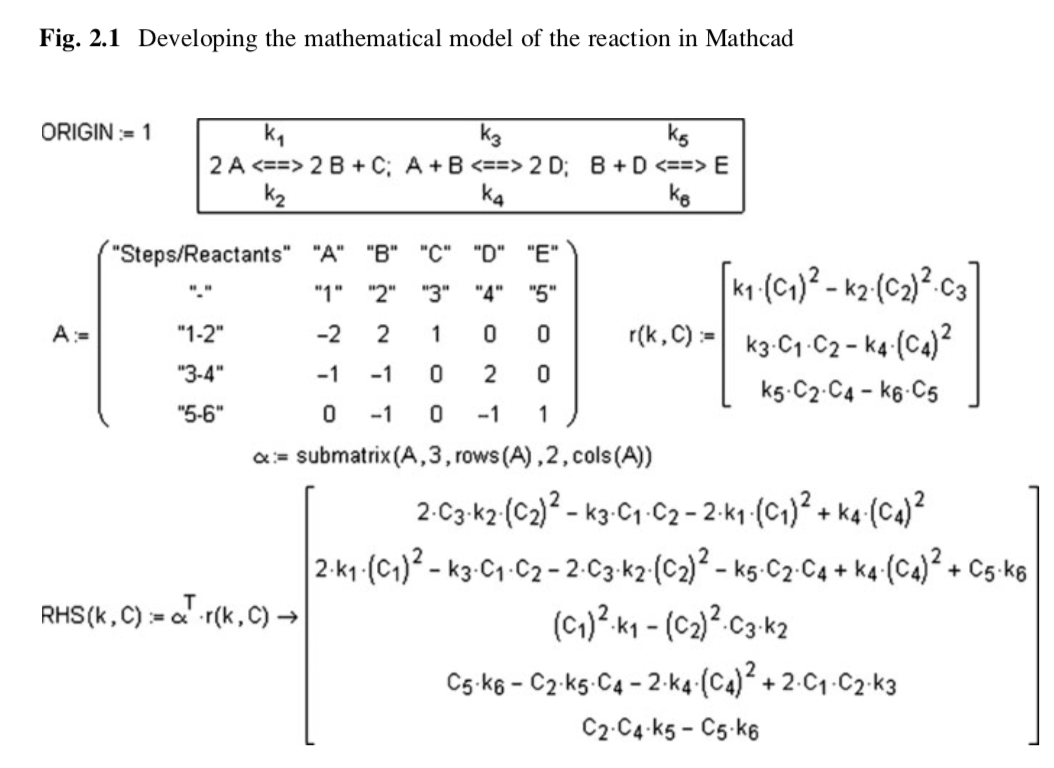

In [28]:
# A --> B + 2C
# A --> B + D
# A --> F
# F --> B + E

def build_concentartion(counter, number):
    
#    concentration = ''
    if abs(float(number)) == 1:
        concentration = '* y[%s] ' % counter
    else:    
        concentration = '* y[%s] ** %s ' % (counter, abs(float(number)))
        
    return concentration

def build_rate(reac, spc_list, matrix, index, speciesindices):
    concentration_f = ''
    concentration_r = ''
    rate_f = 'kf[%s] ' %index
    rate_r = '- kr[%s]' %index
    for x in range (len(reac)):
        species = reac[x][1]
        for i in range (len(spc_list)):
            if i == speciesindices[species]:
                matrix[index][i] = float(reac[x][0])
                if float(reac[x][0]) < 0:
                    concentration_f += build_concentartion( i, reac[x][0])
                else:
                    concentration_r += build_concentartion( i, reac[x][0])
    
    rate_reac = rate_f + concentration_f + rate_r + concentration_r
    
    return rate_reac
            
        
         
def build_stoic_matrix(complete_list, species_list, species_indices):

    matrix = np.zeros((len(complete_list),len(species_list)), dtype = float)
    rate_final = []
    for rxnindex, reac_list in enumerate(complete_list):
        rate = build_rate(reac_list, species_list, matrix, rxnindex, species_indices)
        rate_final.append(rate)
    return matrix, rate_final

In [29]:
matrix, rate_reac = build_stoic_matrix(reac_prod_list, unique_species, speciesindices)
matrix
#rate_reac

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.7, 0. , 0. , ..., 3.9, 0.4, 1.8],
       [0.7, 0. , 0. , ..., 3.9, 0.4, 1.8],
       [0.7, 0. , 0. , ..., 3.9, 0.4, 1.8]])

In [30]:
rate_reac

['kf[0] * y[42] - kr[0]* y[10] * y[39] ',
 'kf[1] * y[42] - kr[1]* y[10] * y[40] ',
 'kf[2] * y[42] - kr[2]* y[10] * y[41] ',
 'kf[3] * y[42] - kr[3]* y[30] ',
 'kf[4] * y[41] - kr[4]* y[34] ',
 'kf[5] * y[34] - kr[5]* y[24] ',
 'kf[6] * y[24] - kr[6]* y[23] * y[22] ',
 'kf[7] * y[24] - kr[7]* y[10] * y[14] ',
 'kf[8] * y[41] - kr[8]* y[10] * y[37] ',
 'kf[9] * y[40] - kr[9]* y[31] ',
 'kf[10] * y[31] - kr[10]* y[32] ',
 'kf[11] * y[32] - kr[11]* y[10] * y[13] ',
 'kf[12] * y[32] - kr[12]* y[7] * y[20] ',
 'kf[13] * y[40] - kr[13]* y[10] * y[38] ',
 'kf[14] * y[38] - kr[14]* y[16] ',
 'kf[15] * y[39] - kr[15]* y[10] * y[38] ',
 'kf[16] * y[39] - kr[16]* y[17] ',
 'kf[17] * y[39] - kr[17]* y[2] ',
 'kf[18] * y[2] - kr[18]* y[8] ',
 'kf[19] * y[8] - kr[19]* y[5] * y[23] ',
 'kf[20] * y[8] - kr[20]* y[10] * y[4] ',
 'kf[21] * y[4] - kr[21]* y[6] ',
 'kf[22] * y[39] - kr[22]* y[10] * y[37] ',
 'kf[23] * y[37] - kr[23]* y[15] ',
 'kf[24] * y[30] - kr[24]* y[10] * y[35] ',
 'kf[25] * y[35] -

In [31]:



# def build_dydt_list(complete_list, species_list, species_indices, rev_rate = 'yes'):
    
#     reac_matrix, rate_reac = build_stoic_matrix(complete_list, species_list, species_indices)
#     dydt_expressions = []
#     for species in species_list:
#         rate_equation = 'dy[%i]/dt = ' % (species_indices[species])
#         i = species_indices[species]
#         for j in range (len(rate_reac)):
#             if reac_matrix[j][i] > 0:
#                 if reac_matrix[j][i] == 1.0:
#                     if rev_rate == 'yes':
#                         rate_equation += '+ %s' %(rate_reac[j])
#                     else:
#                         rate_equation += '+ %s' %(re.split('-', rate_reac[j])[0])
#                 else:
#                     rate_equation += '+ %1.2f * %s' %(reac_matrix[j][i], re.split('-', rate_reac[j])[0])
#                     if rev_rate == 'yes':
#                         rate_equation += '- %1.2f * %s' %(reac_matrix[j][i], re.split('-', rate_reac[j])[1])
#                     else:
#                         pass
#             elif reac_matrix[j][i] < 0:
#                 if reac_matrix[j][i] == -1.:
#                     rate_equation += '- %s' %(re.split('-', rate_reac[j])[0])
#                     if rev_rate == 'yes':
#                         rate_equation += '+ %s' %(re.split('-', rate_reac[j])[1])
#                     else:
#                         pass
#                 else:
#                     rate_equation += '- %1.2f * %s' %(abs(reac_matrix[j][i]), re.split('-', rate_reac[j])[0])
#                     if rev_rate == 'yes':
#                         rate_equation += '+ %1.2f * %s' %(abs(reac_matrix[j][i]), re.split('-', rate_reac[j])[1])
#                     else: 
#                         pass
#             else:
#                 pass
#         dydt_expressions.append(rate_equation)
    
#     return dydt_expressions
        
#     rate_formation = 'd[%s]/dt = ' % (species)
#     # "entry" is [reaction#, sign of that reaction, coefficient]
#     for entry in species_rxns[species]:
#         if human == 'no':
#             rate_formation += '%s*%s' % \
#             (entry[2], rates_forward[entry[0]].split(' = ')[1])
#             rate_formation += '%s*%s' % \
#             (entry[3], rates_reverse[entry[0]].split(' = ')[1])
#         elif human == 'yes':
#             rate_formation += '%s*rate_f[%s] ' % (entry[2], entry[0])
#             rate_formation += '%s*rate_r[%s] ' % (entry[3], entry[0])
#         else:
#             raise ValueError('human must be a string: yes or no')
#     dydt_expressions.append(rate_formation)



In [32]:
# dydt_list = []
# dydt_list = build_dydt_list(reac_prod_list, unique_species, speciesindices, rev_rate = 'yes')
# dydt_list

In [33]:
def build_eqn_forward(matrix, reaction_rate, rev_rate):
    if matrix > 0:
        sign1 = ' + '
        sign2 = ' - '
    else:
        sign1 = ' - '
        sign2 = ' + '
        
    if abs(matrix) == 1.0:
        rate = sign1 +'%s' %re.split('-', reaction_rate)[0]
        if rev_rate == 'yes':
            rate += sign2 +'%s' %re.split('-', reaction_rate)[1]
        else:
            pass
    else:
        rate = sign1 + '%1.2f * %s' %(matrix, re.split('-', reaction_rate)[0])
        if rev_rate == 'yes':
            rate += sign2 + '%1.2f *%s' %(matrix, re.split('-', reaction_rate)[1])
            
        else:
            pass
# print(rate)
    return rate




def build_dydt_list(complete_list, species_list, species_indices, rev_rate = 'yes'):
    
    reac_matrix, rate_reac = build_stoic_matrix(complete_list, species_list, species_indices)
    dydt_expressions = []
    for species in species_list:
        rate_equation = 'dy[%i]/dt = ' % (species_indices[species])
        i = species_indices[species]
        for j in range (len(rate_reac)):
            if abs(reac_matrix[j][i]) > 0:
                rate_equation += build_eqn_forward(reac_matrix[j][i], rate_reac[j], rev_rate)
#            elif reac_matrix[j][i] < 0:
#                 if reac_matrix[j][i] == -1.:
#                     rate_equation += '- %s' %(re.split('-', rate_reac[j])[0])
#                     if rev_rate == 'yes':
#                         rate_equation += '+ %s' %(re.split('-', rate_reac[j])[1])
#                     else:
#                         pass
#                 else:
#                     rate_equation += '- %1.2f * %s' %(abs(reac_matrix[j][i]), re.split('-', rate_reac[j])[0])
#                     if rev_rate == 'yes':
#                         rate_equation += '+ %1.2f * %s' %(abs(reac_matrix[j][i]), re.split('-', rate_reac[j])[1])
#                     else: 
#                         pass
#                rate_equation += build_eqn_forward(reac_matrix[j][i], rate_reac[j], rev_rate)
            else:
                pass

        dydt_expressions.append(rate_equation)
    
    return dydt_expressions

In [34]:
dydt_list = []
dydt_list = build_dydt_list(reac_prod_list, unique_species, speciesindices, rev_rate = 'yes')
dydt_list

['dy[0]/dt =  + 0.70 * kf[42] * y[39]  - 0.70 * kr[42]* y[43] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[10] ** 2.2 * y[45] ** 1.8  + 0.70 * kf[43] * y[40]  - 0.70 * kr[43]* y[43] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[10] ** 2.2 * y[45] ** 1.8  + 0.70 * kf[44] * y[31]  - 0.70 * kr[44]* y[43] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[10] ** 2.2 * y[45] ** 1.8  + 0.70 * kf[45] * y[32]  - 0.70 * kr[45]* y[43] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[10] ** 2.2 * y[45] ** 1.8  + 0.70 * kf[46] * y[32]  - 0.70 * kr[46]* y[43] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[10] ** 2.2 * y[45] ** 1.8  + 0.70 * kf[47] * y[35]  - 0.70 * kr[47]* y[43] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[10] ** 2.2 * y[45] ** 1.8  + 0.70 * kf[48] * y[2]  - 0.70 * kr[48]* y[43] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[10] ** 2.2 * y[45] ** 1.8  + 0.70 * kf[49] * y[8]  - 0.70 * kr[49]* y[43] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[10] ** 2.2 * y[45] ** 1.8  + 0.70 * kf[50] * y[24]  - 0.70 * kr[50]* y[43] ** 3.9 * y[0] ** 0.7

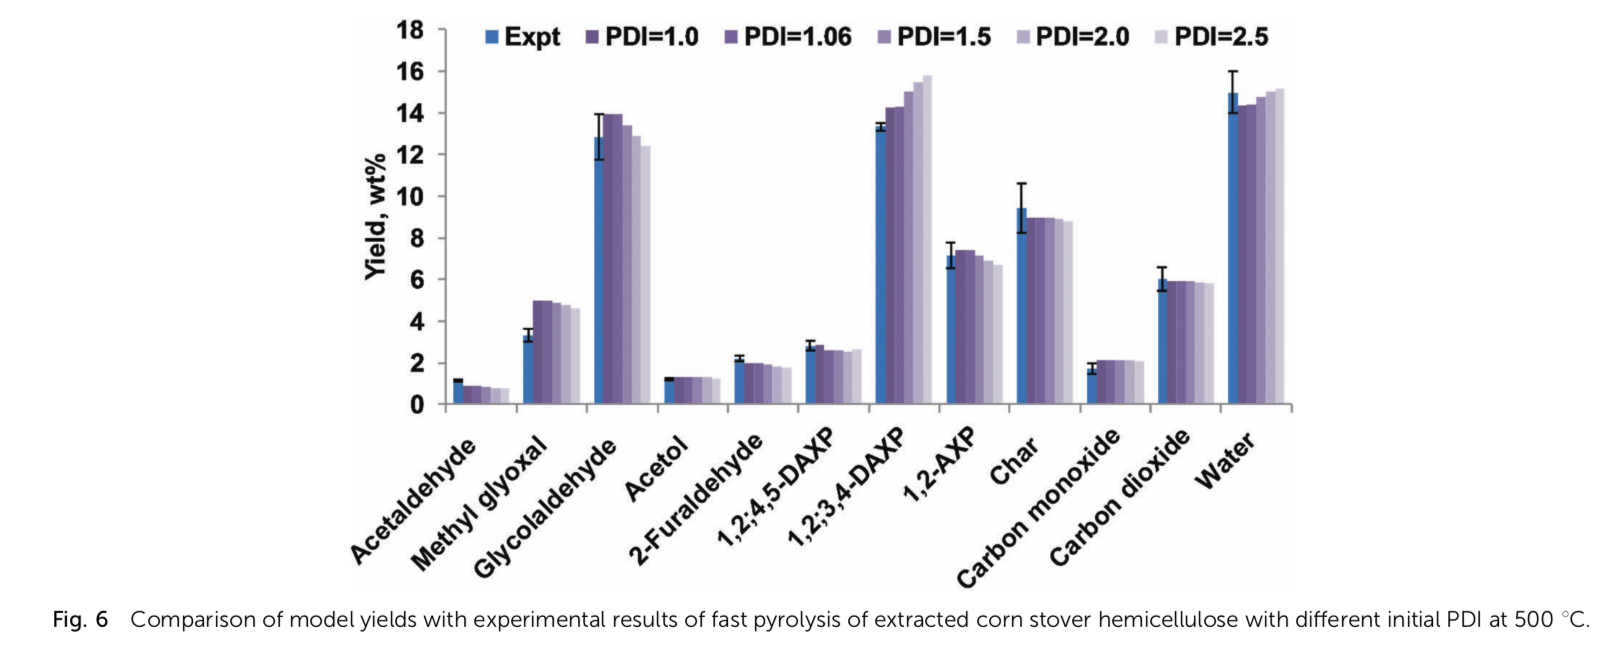

## Sensitivity Analysis

- Sensitivity analysis is the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be divided and allocated to different sources of uncertainty in its inputs. 
- Uncertainty Analysis characterizes the uncertainty in model prediction, without identifying which assump- tions are primarily responsible.
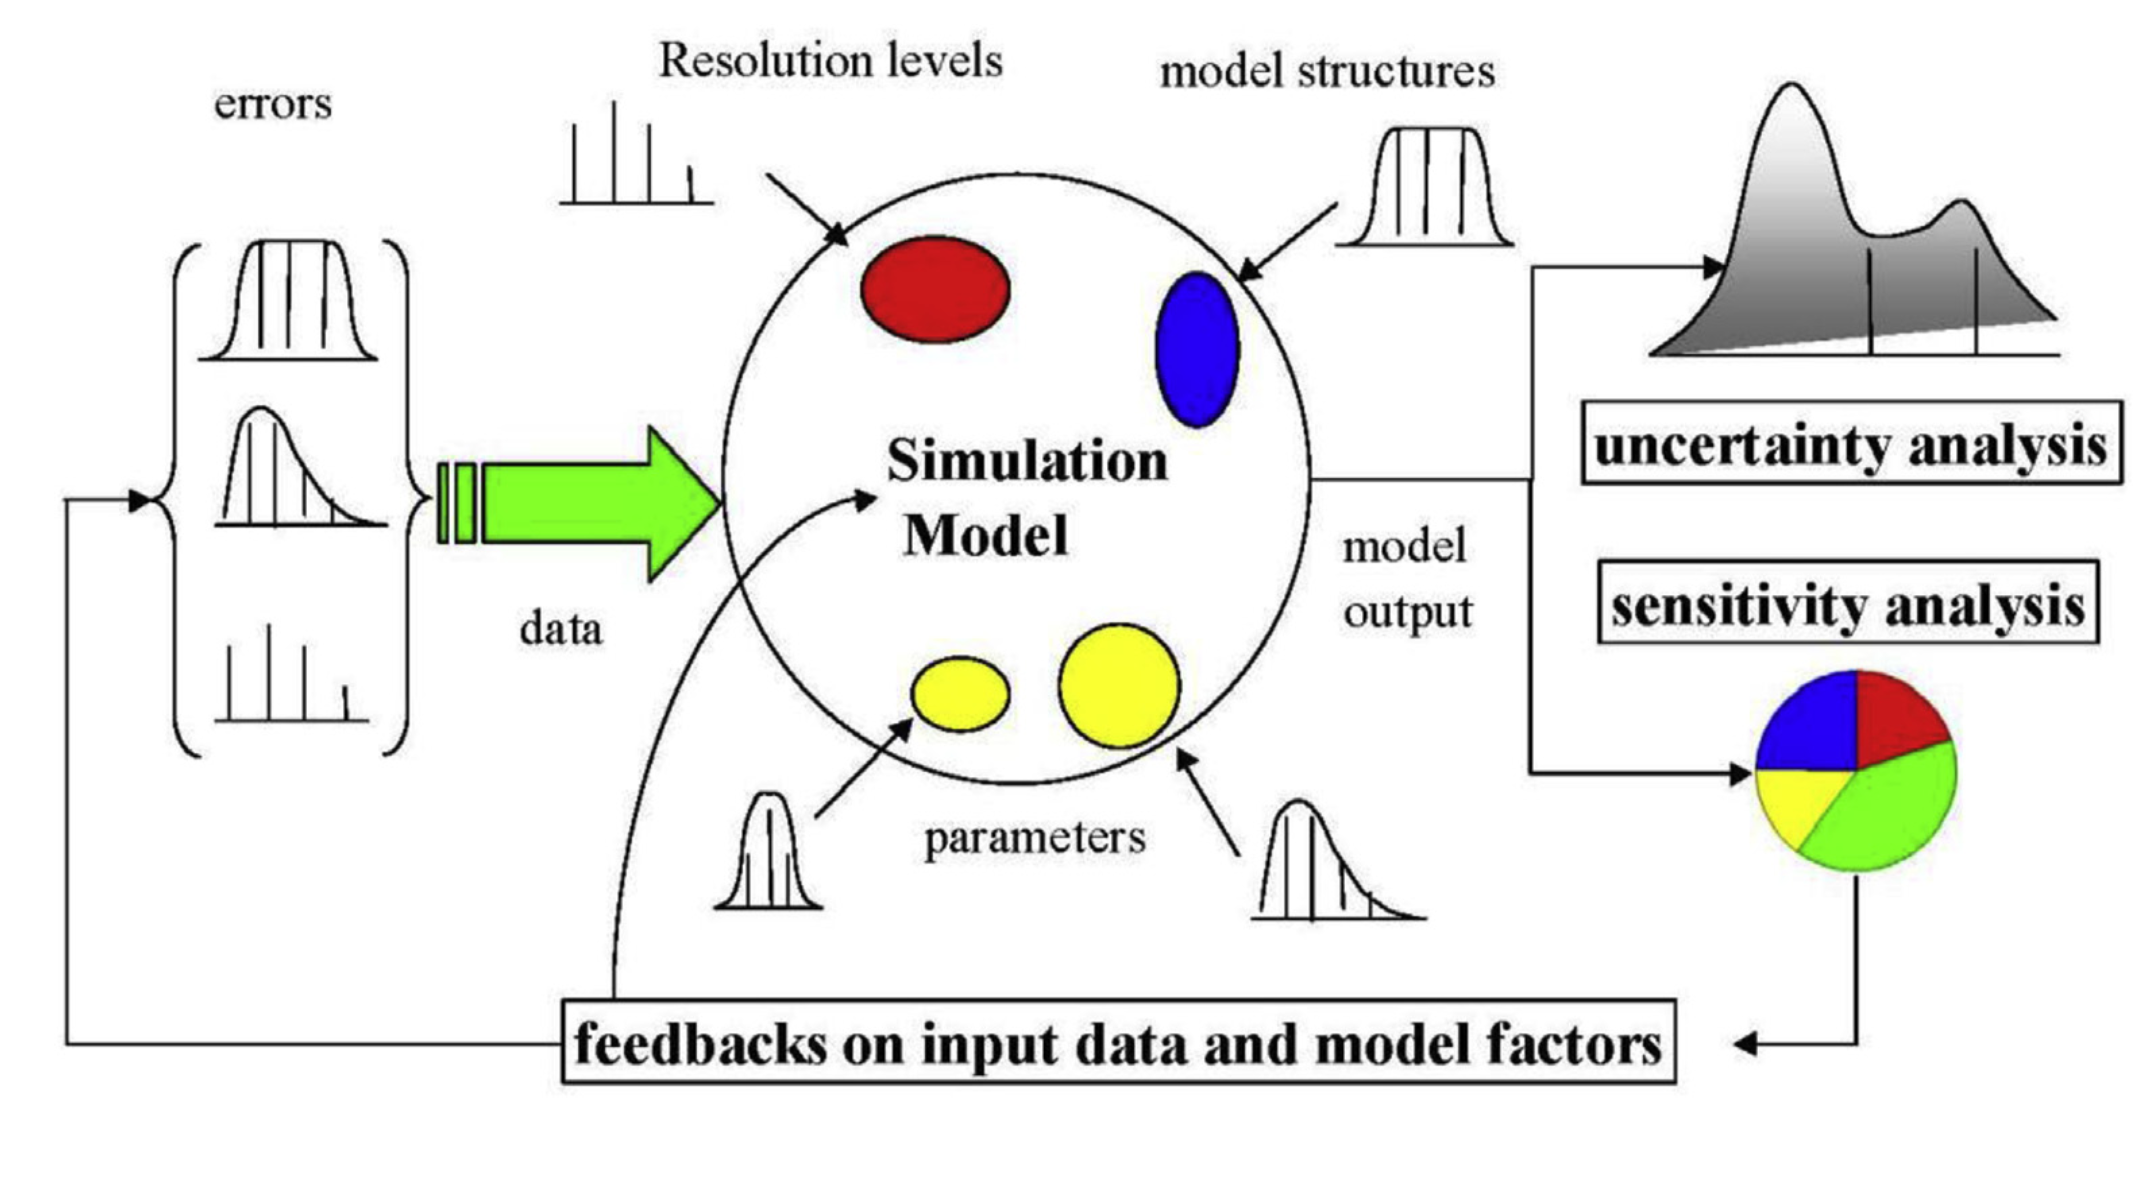

- CVODE has another version CVODES, which can do SA, but is not available through python
- Here, we used SALib to perform SA
- The Saltelli sampler generates N*(2D+2) samples, where in is the number of samples, and D the number of model inputs. The keyword argument **calc_second_order=False** will exclude second-order indices, resulting in a smaller sample matrix with 𝑁 * (𝐷 + 2) rows instead.

In [35]:
#generate parameters for SA

setpath = '/Users/chowdhury/Documents/kmpy_results/SA_data/'
def gen_params(sample_number, input_file_name, output_file_name):
    
    cwd = os.getcwd()
    input_file = setpath + input_file_name
    print(input_file)
    output_file = setpath + output_file_name
    os.system('python -m SALib.sample.saltelli -n {} -p {} -o {}'.format(sample_number, input_file, output_file))

In [36]:
gen_params(20,'params.txt','param_set.txt')

/Users/chowdhury/Documents/kmpy_results/SA_data/params.txt


In [37]:
len(forward_rate_constants)

62

In [38]:
import io
cwd = os.getcwd()
setpath = '/Users/chowdhury/Documents/kmpy_results/SA_data_parallel/'
file_path_read = setpath + 'param_set.txt'
file_path_write = setpath +'model_solutions.txt'
file_input = setpath + 'params.txt'


In [39]:
def analyze_sensitivity(params_file, Y, column, delimiter, order, name,
                        parallel=False, processors=4):
    """
    Perform the sensitivity analysis after you have run your model
    with all the parameters from gen_params().  This is done from
    the command line because it is faster and gives the option to
    specify the column of the results file to analyze.  Parallel
    processing is possible.  Results are saved to a file using the
    name parameter.
    Parameters
    ----------
    problem    : str
                 the path to the saparams* file that contains
                 the problem definition.
    Y          : str
                 the path to the results file.  Results should
                 be in a file without a header.  Each line of the file must
                 contain results that correspond to the same line of the
                 param_sets generated in gen_params().
    column     : int
                 integer specifying the column number of the results to
                 analyze (zero indexed).
    delimiter  : str
                 string specifying the column delimiter used in the results.
    order      : int
                 the maximum order of sensitivity indices [1 or 2].
    name       : str
                 the name of the output measure to use when saving
                 the sensitivity analysis results to a file.
    parallel   : bool, optional
                 boolean indicating whether to use parallel processing.
    processors : int, optional
                 if parallel is True, this is an integer specifying the number
                 of processors to use.
    Returns
    --------
    None
    """
    out_file = setpath + 'analysis_{}.txt' .format(name)
    print(out_file)
    print(processors)
    if parallel:      
        os.system('python -m SALib.analyze.sobol -p {} -Y {} -c {} --delimiter {} '
             '--max-order {} --parallel --processors {} > {}'
             .format(params_file, Y, column, delimiter, order, processors, out_file))
    else:
        os.system('python -m SALib.analyze.sobol -p {} -Y {} -c {} '
             '--delimiter {} --maxorder {} > {}'
             .format(params_file, Y, column, delimiter, order, out_file))

In [40]:
analyze_sensitivity(file_input, file_path_write, speciesindices['O=CCO'], "\'\t'", 2,'glycolaldehyde', parallel=True)

/Users/chowdhury/Documents/kmpy_results/SA_data_parallel/analysis_glycolaldehyde.txt
4


In [41]:
analyze_sensitivity(file_input, file_path_write, speciesindices['O=Cc1ccco1'], "\'\t'", 2,'furfural', parallel=True)

/Users/chowdhury/Documents/kmpy_results/SA_data_parallel/analysis_furfural.txt
4


In [40]:
filenames = [filename for filename in os.listdir(
                setpath) if filename.startswith('analysis')]
filenames

['analysis_furfural.txt', 'analysis_glycolaldehyde.txt']

In [51]:
def parse_SA_analysis(path):

    filenames = [filename for filename in os.listdir(
                     path) if filename.startswith('analysis')]

    dict_dfs = {}

    for filename in filenames:
        name = filename[9:].replace('.txt', '')
        #print(name)

        with open(setpath + filename) as result:
            contents = []
            contents.append(result.readlines())
    #        print(contents)
           # find the line number in the file where 2nd order results appear
            for j, line in enumerate(contents[0]):

                # End this loop when you reach the line that separates
                # the first/total indices from the second order indices
                if line.startswith('\n'):
                    break
              # If no second order indices in file
                else:
                    j = False


            # If there are second order indices in the file
            if j:
                dict_dfs[name] = [pd.read_csv(path + filename, sep=' ',
                                          nrows=(j - 1)),
                                  pd.read_csv(path + filename, sep=' ',
                                                  skiprows=j)]
            else:
                dict_dfs[name] = [pd.read_csv(path + filename, sep=' '),
                                  False]
    return dict_dfs

sens_dfs = parse_SA_analysis(setpath)
sens_dfs

{'furfural': [   Parameter        S1   S1_conf        ST   ST_conf
  0         k0  0.032670  0.016743  0.045633  0.010896
  1         k1  0.021099  0.013463  0.075545  0.020192
  2         k2  0.001617  0.006058  0.014499  0.005425
  3         k3  0.069451  0.028068  0.229943  0.041960
  4         k4  0.000003  0.000006  0.000000  0.000000
  ..       ...       ...       ...       ...       ...
  57       k57  0.000002  0.000003  0.000000  0.000000
  58       k58 -0.000003  0.000008  0.000000  0.000000
  59       k59 -0.000006  0.000027  0.000000  0.000000
  60       k60  0.000001  0.000002  0.000000  0.000000
  61       k61  0.040751  0.016836  0.139879  0.027435
  
  [62 rows x 5 columns],      Parameter_1 Parameter_2        S2   S2_conf
  0             k0          k1 -0.026554  0.024811
  1             k0          k2 -0.028884  0.023788
  2             k0          k3 -0.030292  0.025618
  3             k0          k4 -0.029702  0.023481
  4             k0          k5 -0.029702  0.023

In [75]:
def get_top_ones(path, species, coeff='total', number = 5):
    
    sens_dfs = parse_SA_analysis(path)

    df = sens_dfs[species][0]
    #df = sens_dfs['glycoaldehyde'][0]
    top = int(number)
    # Initialize boolean checks and check dataframe structure
    if (('S1' not in df) or ('ST' not in df) or ('Parameter' not in df) or
       ('ST_conf' not in df) or ('S1_conf' not in df)):
        raise Exception('Dataframe not formatted correctly')

    if coeff == 'total':
        df['placeholder'] = abs(df.ST)
    else:
        df['placeholder'] = abs(df.S1)
    
    df = df.nlargest(top, 'placeholder')
    df = df.drop('placeholder', axis = 1)
    df = df.reset_index(drop=True)
    return df

df_top = get_top_ones(setpath, 'furfural')
print(df_top)

  Parameter        S1   S1_conf        ST   ST_conf
0       k24  0.298413  0.059470  0.616105  0.072937
1        k3  0.069451  0.028068  0.229943  0.041960
2       k26  0.063638  0.021618  0.194777  0.039143
3       k61  0.040751  0.016836  0.139879  0.027435
4        k1  0.021099  0.013463  0.075545  0.020192


In [76]:
def defaultDrawOptions():
    '''This function returns an RDKit drawing options object with 
    default drawing options.'''

    opts = Draw.DrawingOptions()
    # opts.elemDict = defaultdict(lambda: (0,0,0)) # all atoms are black
    opts.noCarbonSymbols = True
    opts.selectColor = (1, 0, 0)
    opts.wedgeBonds = True
    return opts

def moltoimage(mol, max_size=(500, 500), kekulize=True, options=None,
               canvas=None, **kwargs):
    '''Wrapper for RDKit's MolToImage. If mol == None, an arrow is drawn'''

    if not options:
        options = defaultDrawOptions()
    if mol == '->':
        subImgSize = (16, 16)
        img, canvas = Draw._createCanvas(subImgSize)
        p0 = (10, subImgSize[1]//2)
        p1 = (subImgSize[0]-10, subImgSize[1]//2)
        p3 = (subImgSize[0]-20, subImgSize[1]//2-10)
        p4 = (subImgSize[0]-20, subImgSize[1]//2+10)
        print('{}'.format(p1))
        canvas.addCanvasLine(p0, p1, lineWidth=2, color=(0, 0, 0))
        canvas.addCanvasLine(p3, p1, lineWidth=2, color=(0, 0, 0))
        canvas.addCanvasLine(p4, p1, lineWidth=2, color=(0, 0, 0))
        if hasattr(canvas, 'flush'):
            canvas.flush()
        else:
            canvas.save()
        return img
    elif mol is not None:
        return Draw.MolToImage(mol, size=max_size, kekulize=kekulize, options=options,
                               canvas=canvas, **kwargs)
    else:  # retro arrow or error
        subImgSize = (80, 80)
        (a, b) = subImgSize
        img, canvas = Draw._createCanvas(subImgSize)
        canvas.addCanvasLine((10, b//2-7), (a-17, b//2-7),
                             lineWidth=2, color=(0, 0, 255))
        canvas.addCanvasLine((10, b//2+7), (a-17, b//2+7),
                             lineWidth=2, color=(0, 0, 255))
        canvas.addCanvasLine((a-24, b//2-14), (a-10, b//2),
                             lineWidth=2, color=(0, 0, 255))
        canvas.addCanvasLine((a-24, b//2+14), (a-10, b//2),
                             lineWidth=2, color=(0, 0, 255))
        if hasattr(canvas, 'flush'):
            canvas.flush()
        else:
            canvas.save()
        return img


def TrimImgByWhite(img, padding=0):
    '''This function takes a PIL image, img, and crops it to the minimum rectangle 
    based on its whiteness/transparency. 5 pixel padding used automatically.'''

    # Convert to array
    as_array = np.array(img) # N x N x (r,g,b,a)
#    print(as_array)

    # Set previously-transparent pixels to white
    as_array[as_array[:, :, 3] == 0] = [255, 255, 255, 255]

    # Content defined as non-white and non-transparent pixel
    has_content = np.sum(as_array, axis=2, dtype=np.uint32) != 255 * 4
    xs, ys = np.nonzero(has_content)


    # Crop down
    x_range = max([min(xs) - 5, 0]), min([max(xs) + 5, as_array.shape[0]])
    y_range = max([min(ys) - 5, 0]), min([max(ys) + 5, as_array.shape[1]])

    as_array_cropped = as_array[
        x_range[0]:x_range[1], y_range[0]:y_range[1], 0:3]

    img = Image.fromarray(as_array_cropped, mode='RGB')

    return ImageOps.expand(img, border=padding, fill=(255, 255, 255, 0))

def StitchPILsHorizontally(imgs):
    '''This function takes a list of PIL images and concatenates
    them onto a new image horizontally, with each one
    vertically centered.'''

    # Create blank image (def: transparent white)
    heights = [img.size[1] for img in imgs]
    height = max(heights)
    widths = [img.size[0] for img in imgs]
    width = sum(widths)

    res = Image.new('RGBA', (width, height), (255, 255, 255, 255))

    # Add in sub-images
    for i, img in enumerate(imgs):
        offset_x = sum(widths[:i])  # left to right
        offset_y = (height - heights[i]) / 2
        res.paste(img, (int(offset_x), int(offset_y)))

    return res


def StitchPILsVertically(imgs):
    '''This function takes a list of PIL images and concatenates
    them onto a new image horizontally, with each one
    vertically centered.'''

    # Create blank image (def: transparent white)
    heights = [img.size[1] for img in imgs]
    height = sum(heights)
    widths = [img.size[0] for img in imgs]
    width = max(widths)

    res = Image.new('RGBA', (width, height), (255, 255, 255, 255))

    # Add in sub-images
    for i, img in enumerate(imgs):
        offset_x = (width - widths[i]) / 2  # left to right
        offset_y = sum(heights[:i])
        res.paste(img, (int(offset_x), int(offset_y)))

    return res


def ReactionToImage(rxn, dummyAtoms=False, kekulize=True, options=None, **kwargs):
    '''Modification of RDKit's ReactionToImage to allow for each molecule 
    to have a different drawn size. rxn is an RDKit reaction object
    warning: this function adds hydrogens as it sees fit'''
    # Extract mols from reaction
    mols = []
    for item in rxn:
        if item == '':
            mols.append(None)
        else:
            mol = Chem.MolFromSmiles(item)
            Draw.MolToImage(mol, kekulize=True)
            mols.append(mol)


#    Generate images for all molecules/arrow
    imgs = [TrimImgByWhite(moltoimage(
        mol, kekulize=kekulize, options=options), padding=1) for mol in mols]
        
    # Combine
    return StitchPILsHorizontally(imgs)

[['O=C[C@@H](O)[C@H](O)[C@@H](O)CO', '', 'O', 'O=C[C@H]1OC[C@H](O)[C@H]1O'], ['O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O', '', 'O=C[C@@H](O)[C@H](O)[C@@H](O)CO'], ['O=CC1=C[C@@H](O)CO1', '', 'O', 'O=Cc1ccco1'], ['O=CC1=C[C@@H](O)CO1', '', '[C]', 'C(=O)=O', '[C]=O', 'O', '[HH]'], ['O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O', '', 'O', 'OC1=COC[C@@H](O)[C@@H]1O']]


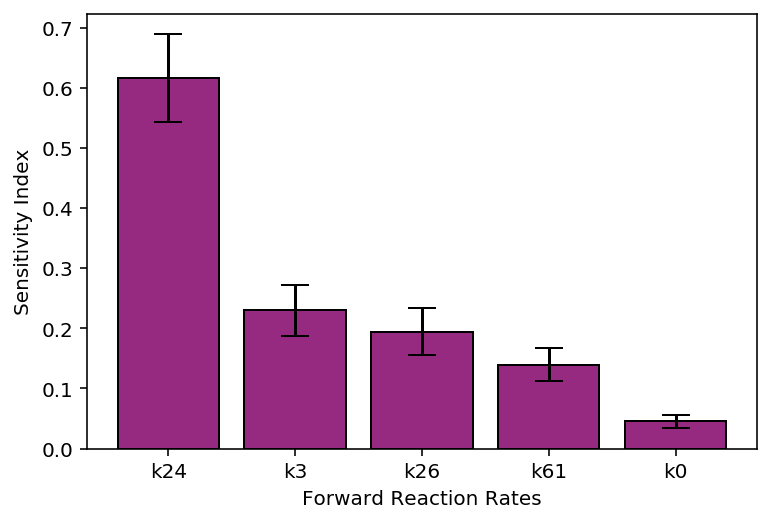

In [78]:
%config InlineBackend.figure_format = 'retina'

def build_reaction(reac):
    
    reactants = []
    products = []
    for species in reac:
        if (float(species[0])) < 0:
            reactants.append(species[1])
        else:
            products.append(species[1])
    
    seperator = ['']
    reaction_list = reactants + seperator + products
    
    return reaction_list

def plot_sensitivity_results(df, species):

    stacked = False
    if len(df) <= 20:
        if stacked is False:

            sensitivity = pd.Series(df.ST)
            parameter = pd.Series(df.Parameter)
            order = np.array(['ST']*len(df))
            confidence = pd.Series(df.ST_conf)
#            yerr = [x + e for x,e in zip(sensitivity, confidence) ]
#            lower = [x - e/2 for x,e in zip(sensitivity, confidence) ]

    barWidth = 0.8
    
    plt.bar(parameter, sensitivity, width = barWidth, color = "#962980", edgecolor = 'black', yerr=confidence, capsize=7)
    plt.ylabel('Sensitivity Index')
    plt.xlabel('Forward Reaction Rates')


def draw_top_reactions(path, species, completelist, number=5, save_image='yes'):
    
    df_top = get_top_ones(path, species, number)
    parameters = df_top.Parameter.values
    reaction_numbers = [int(parameters[i][1:]) for i in range(number)]
    
    if save_image:
        save_top_reactions(path, reaction_numbers, species, completelist)
    
    plot_sensitivity_results(df_top, species)

#        print(reaction)
#    return rxn_strings
        


def save_top_reactions(image_path, reactions, species, completelist):
    
    
    rxn_strings = []
    
    for number in reactions:
        reaction = completelist[number]
        rxn_strings.append(build_reaction(reaction))
    print(rxn_strings)
#    rxns = [ChemReac.ReactionFromSmarts(rxn_str) for rxn_str in rxn_strings]

#    ind_image = ReactionToImage(rxns[1])   
    ind_image = [ReactionToImage(rxn) for rxn in rxn_strings]
    rxn_image = StitchPILsVertically(ind_image)
    rxn_image.save(image_path +'sensitive_reactions_{}.png' .format(species))


draw_top_reactions(setpath, 'furfural', reac_prod_list)
    

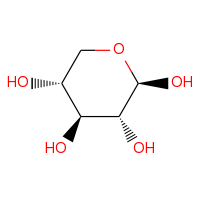

In [49]:

mol = Chem.MolFromSmiles('O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O')
Draw.MolToImage(mol, kekulize=True, size = (200,200))


#nn

In [ ]:
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Whisker
from bokeh.models import HoverTool
from bokeh.plotting import show, output_notebook


def plot_sensitivity_results_bokeh(df, species):

    stacked = False
    if len(df) <= 20:
        if stacked is False:

            sensitivity = pd.Series(df.ST)
            parameter = pd.Series(df.Parameter)
            order = np.array(['ST']*len(df))
            confidence = pd.Series(df.ST_conf)
            upper = [x + e/2 for x,e in zip(sensitivity, confidence) ]
            lower = [x - e/2 for x,e in zip(sensitivity, confidence) ]

    source = ColumnDataSource(data=dict(sensitivity=sensitivity, parameter=parameter, upper=upper, lower=lower))

    p = figure(x_range=parameter, plot_height=350, toolbar_location=None, title="Values", y_range=(0,0.8))

    from bokeh.transform import factor_cmap
    p.vbar(x='parameter', top='sensitivity', source=source, width=0.9, legend = 'parameter',
          fill_color=factor_cmap('parameter', palette=["#962980","#295f96","#29966c","#968529", "#a1d99b"],
                                                      factors=parameter))
    p.add_layout(
        Whisker(source=source, base="parameter", upper="upper", lower="lower", level="overlay")
    )

    p.xgrid.grid_line_color = None
    p.legend.orientation = "horizontal"
    p.legend.location = "top_center"

    show(p)

In [ ]:
plot_sensitivity_results()

In [ ]:
# s = '[NH2:1]-[C:2](=[O:3])-[c:4]1:[cH:5]:[cH:6]:[cH:7]:[n+:8](-[C@@H:10]2-[O:11]-[C@H:12](-[CH2:13]-[O:14]-[P:15](-[O:16])(=[O:17])-[O:18]-[P:19](-[O:20])(=[O:21])-[O:22]-[CH2:23]-[C@H:24]3-[O:25]-[C@@H:26](-[n:31]4:[cH:32]:[n:33]:[c:34]5:[c:35](-[NH2:36]):[n:37]:[cH:38]:[n:39]:[c:40]:4:5)-[C@H:27](-[OH:28])-[C@@H:29]-3-[OH:30])-[C@@H:41](-[OH:42])-[C@H:43]-2-[OH:44]):[cH:9]:1'
# print()
#print(s)
s ='O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O'
print(s)
m = Chem.MolFromSmiles(s)
sma = Chem.MolToSmarts(m, isomericSmiles=True)
print(sma)

In [ ]:
m = Chem.MolFromSmarts(sma)
mm = Chem.MolToSmiles(m)
print(mm)

In [ ]:
reaction = [('-1.0', 'O=C[C@@H](O)[C@H](O)[C@@H](O)CO'), ('1.0', 'O=C[C@@H](O)[C@@H](O)CO'), ('1.0', 'C=O')]
print(len(reaction))